# AI Price Fairness Estimator for Secondhand Fashion

## Purpose & Motivation

This notebook develops an AI-powered Price Fairness Checker for secondhand fashion platforms using Vinted data. The project aims to:

- Train a model to estimate fair resale prices using features such as brand, category, condition, and listing details
- Provide value to both sellers (accurate pricing) and buyers (transparent, fair price ranges)
- Address inconsistent and inflated pricing in secondhand marketplaces
- Apply probabilistic anomaly detection using KDE to identify price outliers

## Approach

We'll use Kernel Density Estimation (KDE) to:
1. Find distribution of normal prices for each category without assuming normality
2. Detect listings with extremely low/high prices relative to the distribution
3. Calibrate thresholds using percentiles to flag overpriced/underpriced items

## 1. Data Loading and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the dataset
# Replace 'your_dataset.csv' with the actual path to your Vinted dataset
df = pd.read_csv('vinted_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

Dataset shape: (225, 21)

Column names:
 1. Category
 2. id
 3. Item.Title
 4. Item.Price
 5. Item.Total.Price
 6. Item.Service.Fee
 7. Item.Currency
 8. Item.Brand
 9. Item.Size
10. Item.Status
11. Item.URL
12. Item.Photo.URL
13. Item.Favorites
14. Seller.ID
15. Seller.Username
16. Seller.URL
17. Seller.Photo
18. Is.Business.Seller
19. Is.Promoted
20. Created.Date
21. Timestamp


In [3]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\n" + "="*50 + "\n")
print("First 5 rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Category            225 non-null    object 
 1   id                  225 non-null    float64
 2   Item.Title          225 non-null    object 
 3   Item.Price          225 non-null    float64
 4   Item.Total.Price    225 non-null    float64
 5   Item.Service.Fee    225 non-null    float64
 6   Item.Currency       225 non-null    object 
 7   Item.Brand          225 non-null    object 
 8   Item.Size           225 non-null    object 
 9   Item.Status         225 non-null    object 
 10  Item.URL            225 non-null    object 
 11  Item.Photo.URL      225 non-null    object 
 12  Item.Favorites      225 non-null    float64
 13  Seller.ID           225 non-null    float64
 14  Seller.Username     225 non-null    object 
 15  Seller.URL          225 non-null    object 

,Category,id,Item.Title,Item.Price,Item.Total.Price,Item.Service.Fee,Item.Currency,Item.Brand,Item.Size,Item.Status,...,Item.Photo.URL,Item.Favorites,Seller.ID,Seller.Username,Seller.URL,Seller.Photo,Is.Business.Seller,Is.Promoted,Created.Date,Timestamp
0,Blazer,7.741631e+09,Faux Leather Blazer,7.0,8.05,1.05,USD,Stradivarius,S / US 4-6,Good,...,https://images1.vinted.net/t/06_00f83_a931QYPo...,7.0,3.123777e+09,jennal755,https://www.vinted.com/member/3123776863-jenna...,Not Available,No,No,12/11/2025,1.765411e+12
1,Blazer,7.722250e+09,Banana Republic shiny wool blazer,12.0,13.30,1.30,USD,Banana Republic,S / US 4-6,Good,...,https://images1.vinted.net/t/05_0236f_jCBoky2o...,3.0,2.599898e+08,secondsummerthrift,https://www.vinted.com/member/259989769-second...,https://images1.vinted.net/t/04_01af4_3TJEJiRk...,No,No,12/8/2025,1.765151e+12
2,Blazer,7.734678e+09,Zara top,9.0,10.15,1.15,USD,Zara,M / US 8-10,New without tags,...,https://images1.vinted.net/t/06_01caf_QmcRdhfG...,27.0,1.192607e+08,luciegrst02,https://www.vinted.com/member/119260684-lucieg...,https://images1.vinted.net/t/01_01c3e_XLeNfCBS...,No,No,12/9/2025,1.765314e+12
3,Blazer,7.743445e+09,Laura Ashley suede leather black jacket,12.0,13.30,1.30,USD,Laura Ashley,Other,Good,...,https://images1.vinted.net/t/06_015a4_rf53TVZu...,1.0,2.447307e+08,runthis,https://www.vinted.com/member/244730742-runthis,https://images1.vinted.net/t/05_007f6_SAdXSvG5...,No,No,12/11/2025,1.765455e+12
4,Blazer,7.735381e+09,$ 8 ZARA (animal print blazer) The size says L...,8.0,9.10,1.10,USD,Zara,M / US 8-10,Very good,...,https://images1.vinted.net/t/06_0153b_8JXgrE1H...,9.0,2.097670e+08,josyta13,https://www.vinted.com/member/209767009-josyta13,https://images1.vinted.net/t/04_00d2e_xL1ft6GT...,No,No,12/10/2025,1.765329e+12


In [4]:
# Data cleaning and preprocessing
print("Missing values per column:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

print(f"\nDataset shape before cleaning: {df.shape}")

# Remove rows with missing critical information
df_clean = df.dropna(subset=['Item.Price', 'Category', 'Item.Brand']).copy()

# Remove rows with price <= 0
df_clean = df_clean[df_clean['Item.Price'] > 0]

print(f"Dataset shape after cleaning: {df_clean.shape}")
print(f"Removed {df.shape[0] - df_clean.shape[0]} rows ({((df.shape[0] - df_clean.shape[0])/df.shape[0]*100):.1f}%)")

Missing values per column:
Series([], dtype: int64)

Dataset shape before cleaning: (225, 21)
Dataset shape after cleaning: (225, 21)
Removed 0 rows (0.0%)


## 2. Exploratory Data Analysis

In [5]:
# Basic statistics
print("Price Statistics:")
print(df_clean['Item.Price'].describe())

print(f"\nNumber of unique categories: {df_clean['Category'].nunique()}")
print(f"Number of unique brands: {df_clean['Item.Brand'].nunique()}")
print(f"Number of unique statuses: {df_clean['Item.Status'].nunique()}")

Price Statistics:
count    225.000000
mean      15.581067
std       12.934170
min        1.000000
25%        8.000000
50%       12.000000
75%       20.000000
max      100.000000
Name: Item.Price, dtype: float64

Number of unique categories: 9
Number of unique brands: 137
Number of unique statuses: 5


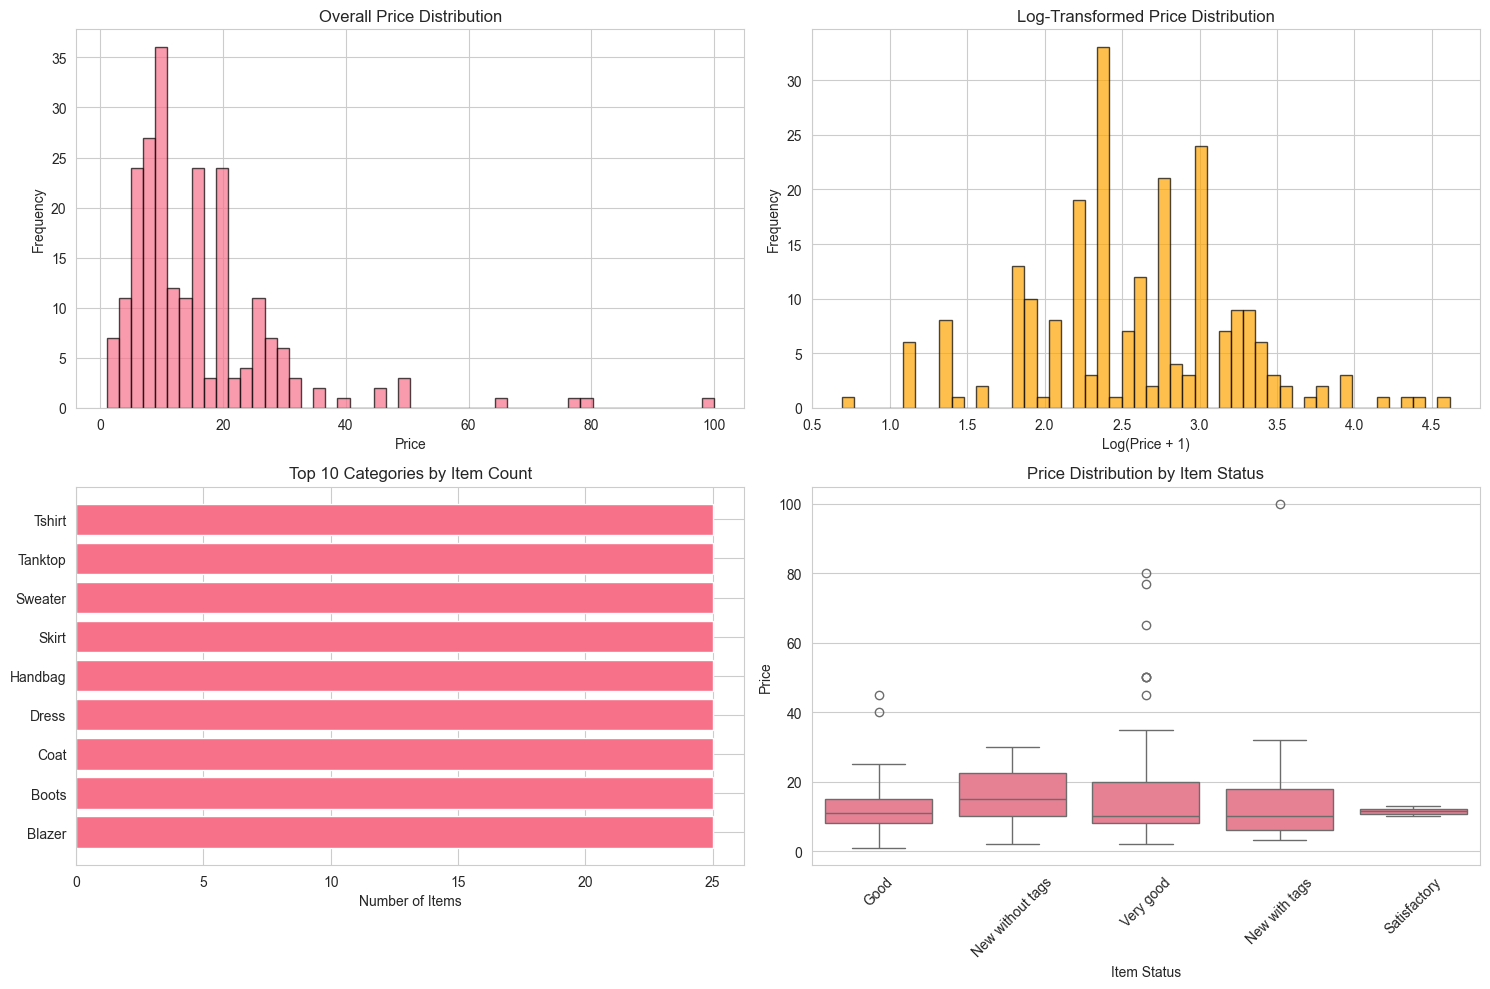

In [6]:
# Visualize price distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Overall price distribution
axes[0, 0].hist(df_clean['Item.Price'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Overall Price Distribution')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')

# Log-transformed price distribution
axes[0, 1].hist(np.log1p(df_clean['Item.Price']), bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[0, 1].set_title('Log-Transformed Price Distribution')
axes[0, 1].set_xlabel('Log(Price + 1)')
axes[0, 1].set_ylabel('Frequency')

# Top 10 categories by count
top_categories = df_clean['Category'].value_counts().head(10)
axes[1, 0].barh(range(len(top_categories)), top_categories.values)
axes[1, 0].set_yticks(range(len(top_categories)))
axes[1, 0].set_yticklabels(top_categories.index)
axes[1, 0].set_title('Top 10 Categories by Item Count')
axes[1, 0].set_xlabel('Number of Items')

# Price by status
if 'Item.Status' in df_clean.columns:
    sns.boxplot(data=df_clean, x='Item.Status', y='Item.Price', ax=axes[1, 1])
    axes[1, 1].set_title('Price Distribution by Item Status')
    axes[1, 1].set_xlabel('Item Status')
    axes[1, 1].set_ylabel('Price')
    axes[1, 1].tick_params(axis='x', rotation=45)
else:
    axes[1, 1].text(0.5, 0.5, 'Item.Status column not available', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Price by Status - Data Not Available')

plt.tight_layout()
plt.show()

In [7]:
# Price analysis by category
category_stats = df_clean.groupby('Category')['Item.Price'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

# Filter categories with at least 20 items for meaningful analysis
category_stats_filtered = category_stats[category_stats['count'] >= 20]
category_stats_filtered = category_stats_filtered.sort_values('mean', ascending=False)

print("Price statistics by category (categories with ≥20 items):")
print(category_stats_filtered.head(10))

Price statistics by category (categories with ≥20 items):
          count   mean  median    std  min     max
Category                                          
Boots        25  29.64    20.0  23.57  5.0  100.00
Coat         25  21.83    25.0   8.40  3.0   40.00
Handbag      25  20.40    15.0  16.44  5.0   77.00
Blazer       25  14.06    10.0   8.16  2.0   35.00
Sweater      25  12.22    10.0   7.90  2.0   29.00
Skirt        25  12.18    10.0   7.35  3.0   31.99
Dress        25  11.92    10.0   6.10  3.0   25.00
Tshirt       25   9.11    10.0   3.74  2.0   16.00
Tanktop      25   8.87     8.0   5.42  1.0   20.00


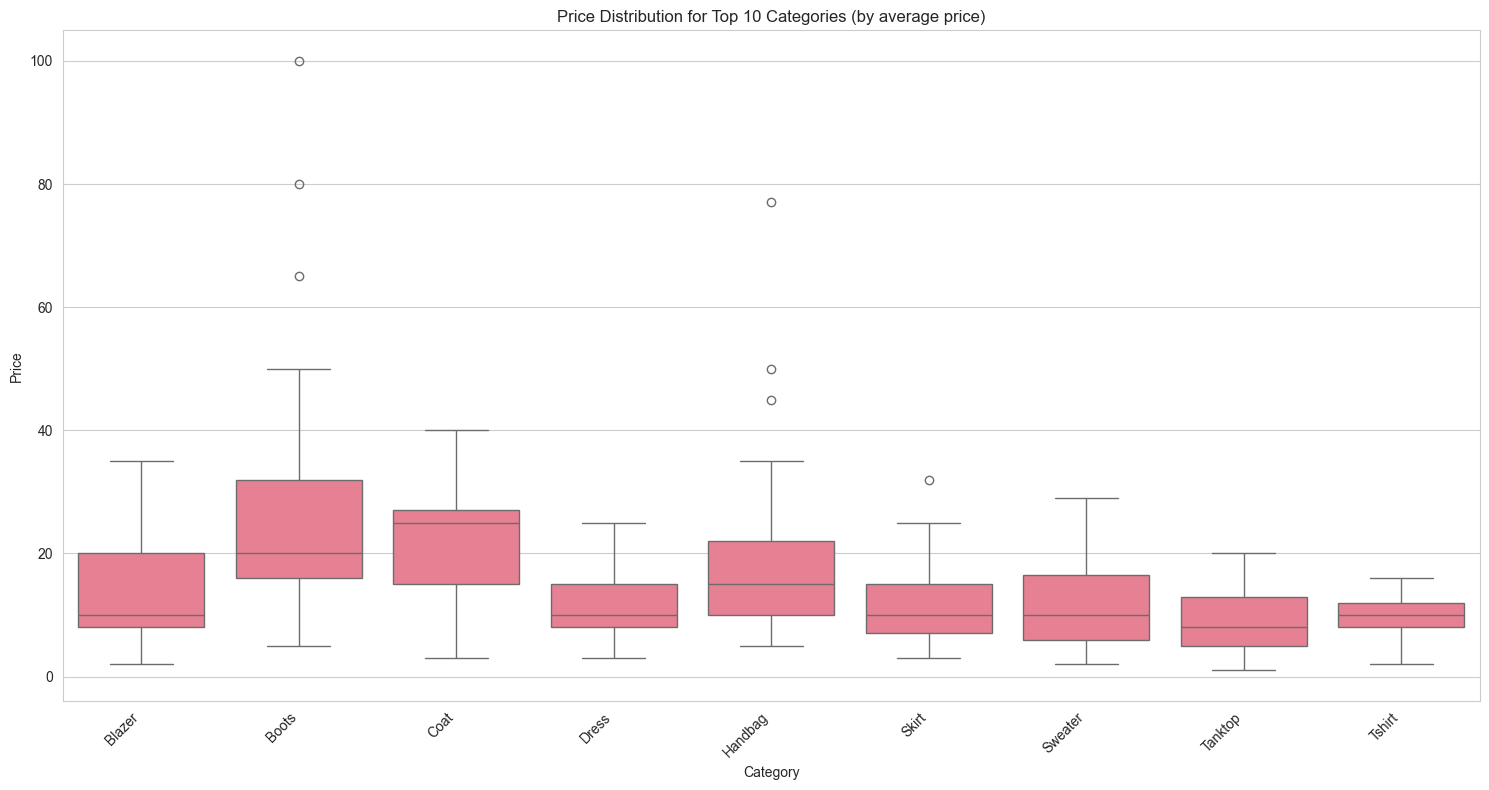

In [8]:
# Visualize price by top categories
top_10_categories = category_stats_filtered.head(10).index
df_top_categories = df_clean[df_clean['Category'].isin(top_10_categories)]

plt.figure(figsize=(15, 8))
sns.boxplot(data=df_top_categories, x='Category', y='Item.Price')
plt.xticks(rotation=45, ha='right')
plt.title('Price Distribution for Top 10 Categories (by average price)')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

## 3. KDE-Based Anomaly Detection for Price Outliers

In [9]:
def detect_price_outliers_kde(category_data, percentile_low=5, percentile_high=95):
    """
    Detect price outliers using Kernel Density Estimation
    
    Parameters:
    - category_data: DataFrame containing price data for a specific category
    - percentile_low: Lower percentile threshold for outlier detection
    - percentile_high: Upper percentile threshold for outlier detection
    
    Returns:
    - Dictionary with outlier information
    """
    prices = category_data['Item.Price'].values
    
    if len(prices) < 10:  # Need sufficient data for KDE
        return {
            'low_outliers': [],
            'high_outliers': [],
            'kde': None,
            'thresholds': None
        }
    
    # Apply log transformation to handle skewed price distribution
    log_prices = np.log1p(prices)
    
    # Fit KDE
    kde = gaussian_kde(log_prices)
    
    # Calculate percentile thresholds
    low_threshold = np.percentile(log_prices, percentile_low)
    high_threshold = np.percentile(log_prices, percentile_high)
    
    # Convert back to original price scale
    low_price_threshold = np.expm1(low_threshold)
    high_price_threshold = np.expm1(high_threshold)
    
    # Identify outliers
    low_outliers = category_data[category_data['Item.Price'] < low_price_threshold].index.tolist()
    high_outliers = category_data[category_data['Item.Price'] > high_price_threshold].index.tolist()
    
    return {
        'low_outliers': low_outliers,
        'high_outliers': high_outliers,
        'kde': kde,
        'thresholds': (low_price_threshold, high_price_threshold),
        'log_thresholds': (low_threshold, high_threshold)
    }

print("KDE outlier detection function defined!")

KDE outlier detection function defined!


In [10]:
# Apply outlier detection to major categories
outlier_results = {}
major_categories = category_stats_filtered.head(5).index  # Top 5 categories with most items

print("Detecting outliers for major categories...")

for category in major_categories:
    print(f"\nProcessing category: {category}")
    category_data = df_clean[df_clean['Category'] == category]
    
    outliers = detect_price_outliers_kde(category_data)
    outlier_results[category] = outliers
    
    print(f"  Items in category: {len(category_data)}")
    print(f"  Low outliers (underpriced): {len(outliers['low_outliers'])}")
    print(f"  High outliers (overpriced): {len(outliers['high_outliers'])}")
    
    if outliers['thresholds']:
        low_thresh, high_thresh = outliers['thresholds']
        print(f"  Price thresholds: ${low_thresh:.2f} - ${high_thresh:.2f}")

print("\nOutlier detection completed!")

Detecting outliers for major categories...

Processing category: Boots
  Items in category: 25
  Low outliers (underpriced): 2
  High outliers (overpriced): 2
  Price thresholds: $6.66 - $76.75

Processing category: Coat
  Items in category: 25
  Low outliers (underpriced): 2
  High outliers (overpriced): 2
  Price thresholds: $8.37 - $29.54

Processing category: Handbag
  Items in category: 25
  Low outliers (underpriced): 2
  High outliers (overpriced): 2
  Price thresholds: $6.19 - $48.96

Processing category: Blazer
  Items in category: 25
  Low outliers (underpriced): 2
  High outliers (overpriced): 2
  Price thresholds: $5.36 - $28.93

Processing category: Sweater
  Items in category: 25
  Low outliers (underpriced): 2
  High outliers (overpriced): 2
  Price thresholds: $2.32 - $28.37

Outlier detection completed!


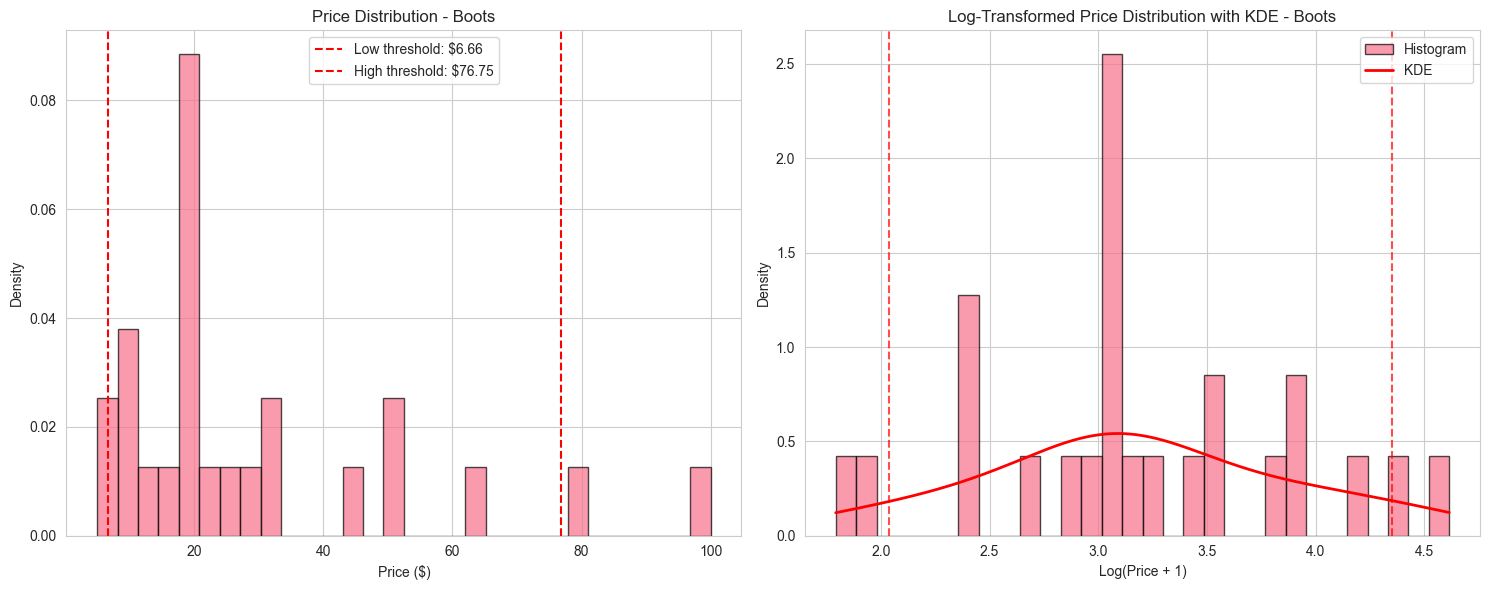

In [11]:
# Visualize KDE and outliers for a sample category
sample_category = major_categories[0]
sample_data = df_clean[df_clean['Category'] == sample_category]
sample_outliers = outlier_results[sample_category]

if sample_outliers['kde'] is not None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original price distribution with outliers
    prices = sample_data['Item.Price'].values
    axes[0].hist(prices, bins=30, alpha=0.7, density=True, edgecolor='black')
    
    # Mark outliers
    if sample_outliers['thresholds']:
        low_thresh, high_thresh = sample_outliers['thresholds']
        axes[0].axvline(low_thresh, color='red', linestyle='--', label=f'Low threshold: ${low_thresh:.2f}')
        axes[0].axvline(high_thresh, color='red', linestyle='--', label=f'High threshold: ${high_thresh:.2f}')
    
    axes[0].set_title(f'Price Distribution - {sample_category}')
    axes[0].set_xlabel('Price ($)')
    axes[0].set_ylabel('Density')
    axes[0].legend()
    
    # Log-transformed distribution with KDE
    log_prices = np.log1p(prices)
    axes[1].hist(log_prices, bins=30, alpha=0.7, density=True, edgecolor='black', label='Histogram')
    
    # Plot KDE
    x_range = np.linspace(log_prices.min(), log_prices.max(), 1000)
    kde_values = sample_outliers['kde'](x_range)
    axes[1].plot(x_range, kde_values, 'r-', linewidth=2, label='KDE')
    
    # Mark thresholds
    if sample_outliers['log_thresholds']:
        low_log, high_log = sample_outliers['log_thresholds']
        axes[1].axvline(low_log, color='red', linestyle='--', alpha=0.7)
        axes[1].axvline(high_log, color='red', linestyle='--', alpha=0.7)
    
    axes[1].set_title(f'Log-Transformed Price Distribution with KDE - {sample_category}')
    axes[1].set_xlabel('Log(Price + 1)')
    axes[1].set_ylabel('Density')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

else:
    print(f"Insufficient data for KDE analysis in category: {sample_category}")

## 4. Price Fairness Estimation Model

In [12]:
# Prepare features for machine learning
def prepare_features(df):
    """
    Prepare features for the price prediction model
    """
    df_features = df.copy()
    
    # Encode categorical variables
    label_encoders = {}
    
    # Use actual column names from the dataset
    categorical_columns = ['Category', 'Item.Brand', 'Item.Status', 'Item.Size']
    
    for col in categorical_columns:
        if col in df_features.columns:
            le = LabelEncoder()
            # Handle missing values
            df_features[col] = df_features[col].fillna('Unknown')
            df_features[col + '_encoded'] = le.fit_transform(df_features[col])
            label_encoders[col] = le
            print(f"Encoded {col}: {len(le.classes_)} unique values")
        else:
            print(f"Warning: Column {col} not found in dataset")
    
    # Create additional features
    if 'Item.Title' in df_features.columns:
        df_features['title_length'] = df_features['Item.Title'].fillna('').str.len()
        df_features['title_word_count'] = df_features['Item.Title'].fillna('').str.split().str.len()
        print("Created title-based features")
    
    if 'Item.Favorites' in df_features.columns:
        df_features['Item.Favorites'] = df_features['Item.Favorites'].fillna(0)
        print("Processed favorites feature")
    
    # Business seller indicator
    if 'Is.Business.Seller' in df_features.columns:
        # Convert Yes/No to True/False
        df_features['Is.Business.Seller'] = df_features['Is.Business.Seller'].fillna('No')
        df_features['Is.Business.Seller'] = df_features['Is.Business.Seller'].map({'Yes': True, 'No': False}).fillna(False)
        print("Processed business seller feature")
    
    return df_features, label_encoders

# Prepare the dataset
df_features, encoders = prepare_features(df_clean)
print("Features prepared successfully!")
print(f"Available encoded features: {[col for col in df_features.columns if col.endswith('_encoded')]}")

Encoded Category: 9 unique values
Encoded Item.Brand: 137 unique values
Encoded Item.Status: 5 unique values
Encoded Item.Size: 28 unique values
Created title-based features
Processed favorites feature
Processed business seller feature
Features prepared successfully!
Available encoded features: ['Category_encoded', 'Item.Brand_encoded', 'Item.Status_encoded', 'Item.Size_encoded']


In [13]:
# Select features for the model
feature_columns = []

# Add encoded categorical features
encoded_features = [col for col in df_features.columns if col.endswith('_encoded')]
feature_columns.extend(encoded_features)

# Add numerical features
numerical_features = ['title_length', 'title_word_count', 'Item.Favorites']
for feature in numerical_features:
    if feature in df_features.columns:
        feature_columns.append(feature)

# Add business seller indicator
if 'Is.Business.Seller' in df_features.columns:
    df_features['is_business_numeric'] = df_features['Is.Business.Seller'].astype(int)
    feature_columns.append('is_business_numeric')

print(f"Selected features for modeling: {feature_columns}")

# Prepare training data
X = df_features[feature_columns].fillna(0)  # Fill any remaining NaN values
y = df_features['Item.Price']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Selected features for modeling: ['Category_encoded', 'Item.Brand_encoded', 'Item.Status_encoded', 'Item.Size_encoded', 'title_length', 'title_word_count', 'Item.Favorites', 'is_business_numeric']

Feature matrix shape: (225, 8)
Target vector shape: (225,)


In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")

Training set size: 180
Test set size: 45

Features scaled successfully!


In [15]:
# Train Random Forest model
print("Training Random Forest model...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
print("Model training completed!")

# Make predictions
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\nModel Performance:")
print(f"{'Metric':<12} {'Train':<12} {'Test':<12}")
print("-" * 36)
print(f"{'MAE':<12} ${train_mae:<11.2f} ${test_mae:<11.2f}")
print(f"{'RMSE':<12} ${train_rmse:<11.2f} ${test_rmse:<11.2f}")
print(f"{'R²':<12} {train_r2:<12.3f} {test_r2:<12.3f}")

Training Random Forest model...
Model training completed!

Model Performance:
Metric       Train        Test        
------------------------------------
MAE          $4.49        $7.16       
RMSE         $7.75        $9.39       
R²           0.679        -0.147      


Top 10 Most Important Features:
               feature  importance
3    Item.Size_encoded    0.273651
6       Item.Favorites    0.194080
0     Category_encoded    0.138025
4         title_length    0.129812
1   Item.Brand_encoded    0.128686
5     title_word_count    0.083792
2  Item.Status_encoded    0.051954
7  is_business_numeric    0.000000


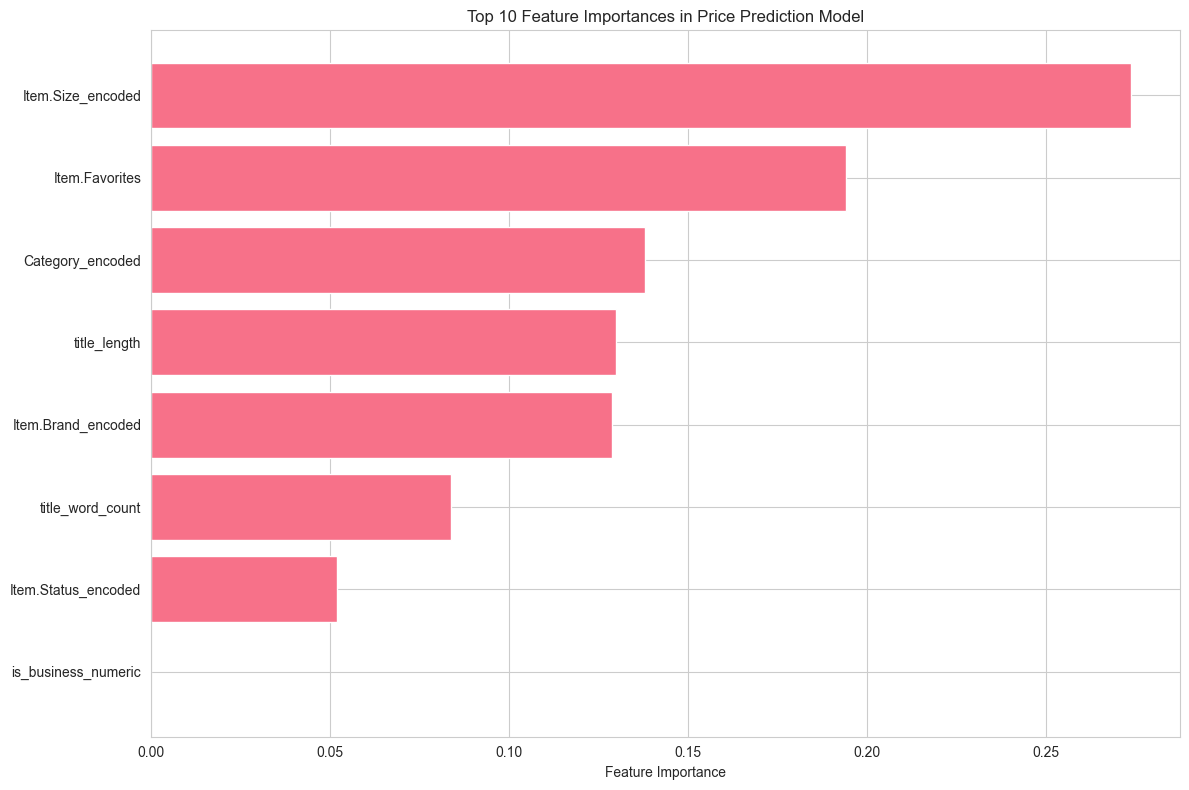

In [16]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances in Price Prediction Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5. Price Fairness Assessment Function

In [17]:
def assess_price_fairness(item_features, actual_price, model, scaler, outlier_results, category):
    """
    Assess the fairness of an item's price using both ML prediction and KDE outlier detection
    
    Parameters:
    - item_features: Feature vector for the item
    - actual_price: The listed price of the item
    - model: Trained ML model
    - scaler: Feature scaler
    - outlier_results: KDE outlier detection results by category
    - category: Item category
    
    Returns:
    - Dictionary with fairness assessment
    """
    # Get ML prediction
    item_features_scaled = scaler.transform([item_features])
    predicted_price = model.predict(item_features_scaled)[0]
    
    # Calculate price difference
    price_difference = actual_price - predicted_price
    price_difference_pct = (price_difference / predicted_price) * 100
    
    # Check KDE-based outlier status
    kde_assessment = "Normal"
    if category in outlier_results and outlier_results[category]['thresholds']:
        low_thresh, high_thresh = outlier_results[category]['thresholds']
        if actual_price < low_thresh:
            kde_assessment = "Significantly Underpriced"
        elif actual_price > high_thresh:
            kde_assessment = "Significantly Overpriced"
    
    # Determine overall fairness assessment
    if abs(price_difference_pct) <= 20:  # Within 20% of predicted price
        fairness = "Fair"
    elif price_difference_pct > 20:
        fairness = "Overpriced"
    else:
        fairness = "Underpriced"
    
    # Combine assessments
    if kde_assessment != "Normal" and fairness != "Fair":
        overall_assessment = f"Confirmed {fairness.lower()} (ML + KDE)"
    elif kde_assessment != "Normal":
        overall_assessment = f"KDE flagged as {kde_assessment.lower()}"
    else:
        overall_assessment = fairness
    
    return {
        'predicted_price': predicted_price,
        'actual_price': actual_price,
        'price_difference': price_difference,
        'price_difference_pct': price_difference_pct,
        'ml_assessment': fairness,
        'kde_assessment': kde_assessment,
        'overall_assessment': overall_assessment
    }

print("Price fairness assessment function defined!")

Price fairness assessment function defined!


In [18]:
# Test the fairness assessment on sample items
print("Testing price fairness assessment on sample items...")

# Select some test samples
sample_indices = np.random.choice(X_test.index, size=5, replace=False)

for idx in sample_indices:
    item_row = df_features.loc[idx]
    item_features = X.loc[idx].values
    actual_price = item_row['Item.Price']
    category = item_row['Category']
    
    assessment = assess_price_fairness(
        item_features, actual_price, rf_model, scaler, 
        outlier_results, category
    )
    
    print(f"\n{'='*50}")
    print(f"Item: {item_row.get('Item.Title', 'N/A')[:50]}...")
    print(f"Category: {category}")
    print(f"Brand: {item_row.get('Item.Brand', 'N/A')}")
    print(f"Actual Price: ${actual_price:.2f}")
    print(f"Predicted Price: ${assessment['predicted_price']:.2f}")
    print(f"Difference: ${assessment['price_difference']:.2f} ({assessment['price_difference_pct']:.1f}%)")
    print(f"ML Assessment: {assessment['ml_assessment']}")
    print(f"KDE Assessment: {assessment['kde_assessment']}")
    print(f"Overall Assessment: {assessment['overall_assessment']}")

Testing price fairness assessment on sample items...

Item: Navy and white tank top 2000s...
Category: Tanktop
Brand: Perfect
Actual Price: $7.00
Predicted Price: $24.31
Difference: $-17.31 (-71.2%)
ML Assessment: Underpriced
KDE Assessment: Normal
Overall Assessment: Underpriced

Item: Hollister Mens Button Down Brown White Striped Dre...
Category: Dress
Brand: Hollister
Actual Price: $8.00
Predicted Price: $15.25
Difference: $-7.25 (-47.5%)
ML Assessment: Underpriced
KDE Assessment: Normal
Overall Assessment: Underpriced

Item: Black and red shirt-sleeved graphic tee with uniqu...
Category: Tshirt
Brand: Gildan
Actual Price: $13.00
Predicted Price: $14.03
Difference: $-1.03 (-7.3%)
ML Assessment: Fair
KDE Assessment: Normal
Overall Assessment: Fair

Item: Beautiful leather blazzer...
Category: Blazer
Brand: style & co.
Actual Price: $10.00
Predicted Price: $11.38
Difference: $-1.38 (-12.1%)
ML Assessment: Fair
KDE Assessment: Normal
Overall Assessment: Fair

Item: Hollister Grey Skir

## 6. Model Evaluation and Visualization

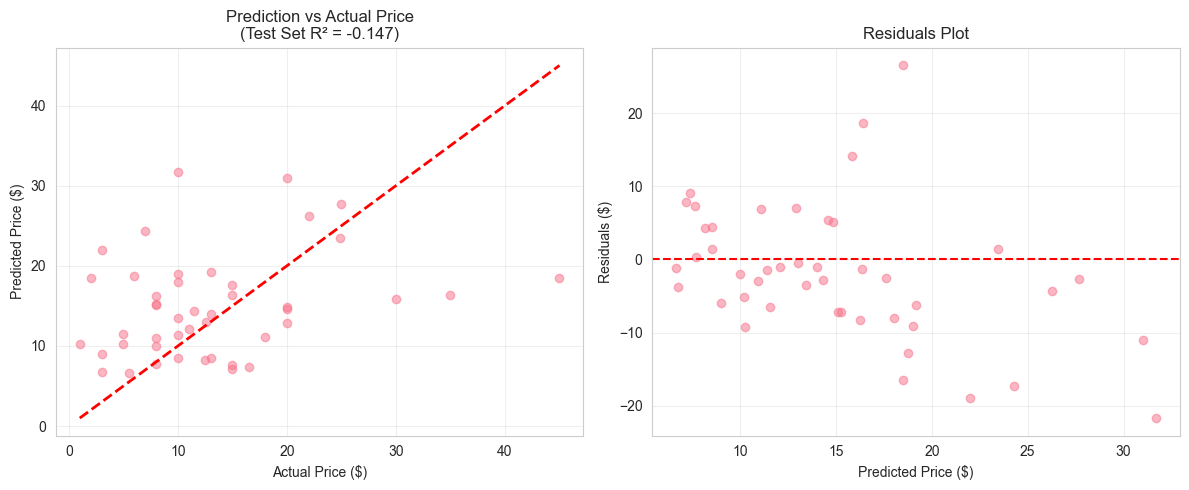

In [19]:
# Prediction vs Actual Price Plot
plt.figure(figsize=(12, 5))

# Subplot 1: Prediction vs Actual (Test Set)
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'Prediction vs Actual Price\n(Test Set R² = {test_r2:.3f})')
plt.grid(True, alpha=0.3)

# Subplot 2: Residuals Plot
plt.subplot(1, 2, 2)
residuals = y_test - y_pred_test
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price ($)')
plt.ylabel('Residuals ($)')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Summary statistics for price fairness across the test set
fairness_results = []

for idx in X_test.index:
    item_row = df_features.loc[idx]
    item_features = X.loc[idx].values
    actual_price = item_row['Item.Price']
    category = item_row['Category']
    
    assessment = assess_price_fairness(
        item_features, actual_price, rf_model, scaler, 
        outlier_results, category
    )
    
    fairness_results.append({
        'index': idx,
        'category': category,
        'actual_price': actual_price,
        'predicted_price': assessment['predicted_price'],
        'ml_assessment': assessment['ml_assessment'],
        'kde_assessment': assessment['kde_assessment'],
        'overall_assessment': assessment['overall_assessment']
    })

fairness_df = pd.DataFrame(fairness_results)

print("Price Fairness Summary (Test Set):")
print("\nML Assessment Distribution:")
print(fairness_df['ml_assessment'].value_counts())

print("\nKDE Assessment Distribution:")
print(fairness_df['kde_assessment'].value_counts())

print("\nOverall Assessment Distribution:")
print(fairness_df['overall_assessment'].value_counts())

Price Fairness Summary (Test Set):

ML Assessment Distribution:
ml_assessment
Underpriced    20
Fair           13
Overpriced     12
Name: count, dtype: int64

KDE Assessment Distribution:
kde_assessment
Normal                       41
Significantly Underpriced     3
Significantly Overpriced      1
Name: count, dtype: int64

Overall Assessment Distribution:
overall_assessment
Underpriced                         17
Fair                                13
Overpriced                          11
Confirmed underpriced (ML + KDE)     3
Confirmed overpriced (ML + KDE)      1
Name: count, dtype: int64


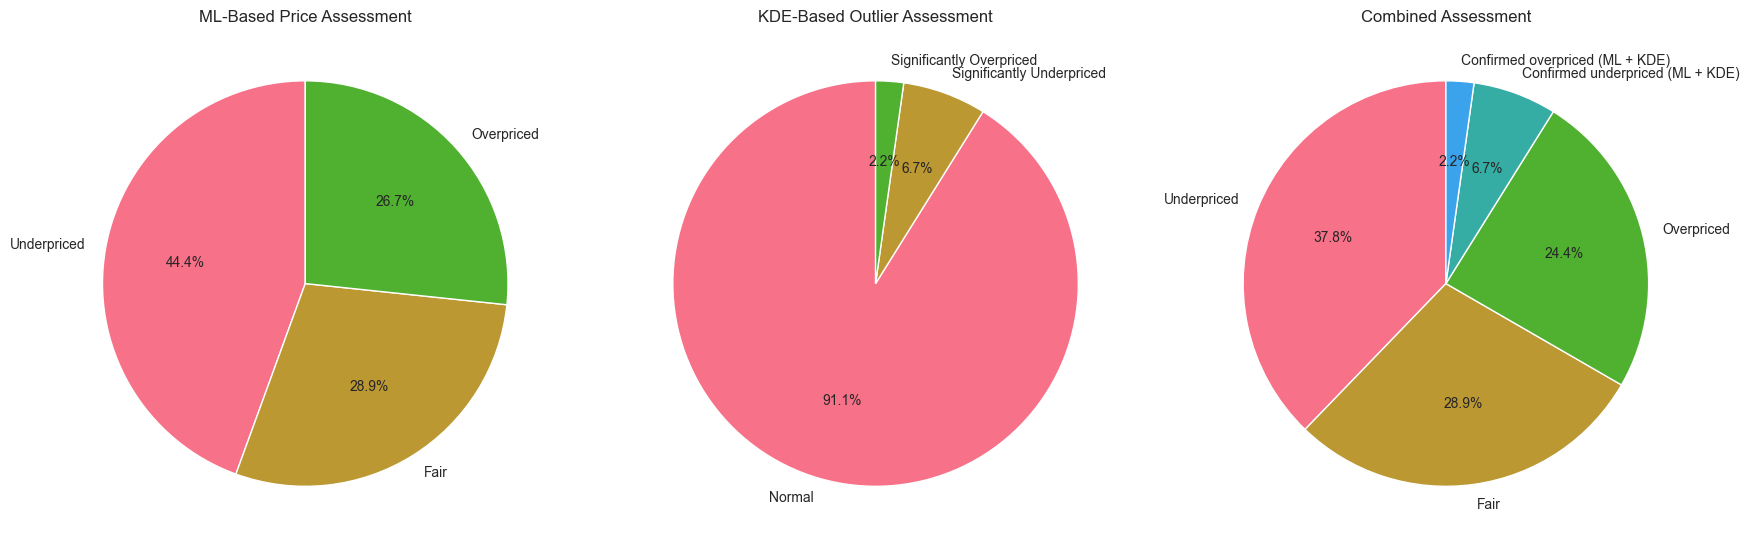

In [21]:
# Visualize fairness assessment distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ML Assessment
ml_counts = fairness_df['ml_assessment'].value_counts()
axes[0].pie(ml_counts.values, labels=ml_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('ML-Based Price Assessment')

# KDE Assessment
kde_counts = fairness_df['kde_assessment'].value_counts()
axes[1].pie(kde_counts.values, labels=kde_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('KDE-Based Outlier Assessment')

# Overall Assessment
overall_counts = fairness_df['overall_assessment'].value_counts()
axes[2].pie(overall_counts.values, labels=overall_counts.index, autopct='%1.1f%%', startangle=90)
axes[2].set_title('Combined Assessment')

plt.tight_layout()
plt.show()

## 7. Practical Application Example

In [22]:
def price_recommendation_tool(category, brand, title="", status="Good", favorites=0, is_business=False):
    """
    Tool for sellers to get price recommendations
    """
    try:
        # Create feature vector for the new item
        features = []
        
        # Category encoding
        if 'Category_encoded' in feature_columns and 'Category' in encoders:
            try:
                if category in encoders['Category'].classes_:
                    features.append(encoders['Category'].transform([category])[0])
                else:
                    # Use most common category as fallback
                    most_common_category = df_clean['Category'].mode()[0]
                    features.append(encoders['Category'].transform([most_common_category])[0])
                    print(f"Unknown category '{category}', using '{most_common_category}' as fallback")
            except:
                features.append(0)
        
        # Brand encoding
        if 'Item.Brand_encoded' in feature_columns and 'Item.Brand' in encoders:
            try:
                if brand in encoders['Item.Brand'].classes_:
                    features.append(encoders['Item.Brand'].transform([brand])[0])
                else:
                    # Use most common brand as fallback
                    most_common_brand = df_clean['Item.Brand'].mode()[0]
                    features.append(encoders['Item.Brand'].transform([most_common_brand])[0])
                    print(f"Unknown brand '{brand}', using '{most_common_brand}' as fallback")
            except:
                features.append(0)
        
        # Status encoding
        if 'Item.Status_encoded' in feature_columns and 'Item.Status' in encoders:
            try:
                if status in encoders['Item.Status'].classes_:
                    features.append(encoders['Item.Status'].transform([status])[0])
                else:
                    # Use most common status as fallback
                    most_common_status = df_clean['Item.Status'].mode()[0]
                    features.append(encoders['Item.Status'].transform([most_common_status])[0])
                    print(f"Unknown status '{status}', using '{most_common_status}' as fallback")
            except:
                features.append(0)
                
        # Size encoding
        if 'Item.Size_encoded' in feature_columns and 'Item.Size' in encoders:
            try:
                # Use most common size as default
                most_common_size = df_clean['Item.Size'].mode()[0]
                features.append(encoders['Item.Size'].transform([most_common_size])[0])
            except:
                features.append(0)
        
        # Add other features
        if 'title_length' in feature_columns:
            features.append(len(title))
        if 'title_word_count' in feature_columns:
            features.append(len(title.split()) if title else 0)
        if 'Item.Favorites' in feature_columns:
            features.append(favorites)
        if 'is_business_numeric' in feature_columns:
            features.append(int(is_business))
        
        # Ensure we have the right number of features
        while len(features) < len(feature_columns):
            features.append(0)
        
        # Trim to exact number needed
        features = features[:len(feature_columns)]
        
        # Make prediction
        features_scaled = scaler.transform([features])
        predicted_price = rf_model.predict(features_scaled)[0]
        
        # Get category price range from KDE if available
        price_range = None
        if category in outlier_results and outlier_results[category]['thresholds']:
            low_thresh, high_thresh = outlier_results[category]['thresholds']
            price_range = (low_thresh, high_thresh)
        
        return {
            'predicted_price': predicted_price,
            'price_range': price_range,
            'recommendation': f"Suggested price: ${predicted_price:.2f}"
        }
    
    except Exception as e:
        print(f"Error in price recommendation: {str(e)}")
        return {
            'error': str(e),
            'recommendation': "Unable to generate price recommendation"
        }

print("Improved price recommendation tool defined!")

Improved price recommendation tool defined!


In [23]:
# Test the price recommendation tool
print("Testing Price Recommendation Tool:")
print("=" * 50)

# Get some sample categories and brands from the data
sample_categories = df_clean['Category'].value_counts().head(3).index.tolist()
sample_brands = df_clean['Item.Brand'].value_counts().head(5).index.tolist()

print(f"Available categories (top 3): {sample_categories}")
print(f"Available brands (top 5): {sample_brands}")
print("\n" + "-" * 50 + "\n")

# Test examples
test_cases = [
    {
        'category': sample_categories[0] if sample_categories else 'Clothing',
        'brand': sample_brands[0] if sample_brands else 'Nike',
        'title': 'Vintage Designer Jacket',
        'status': 'Good'
    },
    {
        'category': sample_categories[1] if len(sample_categories) > 1 else 'Shoes',
        'brand': sample_brands[1] if len(sample_brands) > 1 else 'Adidas',
        'title': 'Limited Edition Sneakers',
        'status': 'Very Good'
    }
]

for i, test_case in enumerate(test_cases, 1):
    print(f"Test Case {i}:")
    recommendation = price_recommendation_tool(**test_case)
    
    print(f"  Category: {test_case['category']}")
    print(f"  Brand: {test_case['brand']}")
    print(f"  Title: {test_case['title']}")
    print(f"  Status: {test_case['status']}")
    
    if 'error' in recommendation:
        print(f"  Error: {recommendation['error']}")
    else:
        print(f"  {recommendation['recommendation']}")
        if recommendation['price_range']:
            low, high = recommendation['price_range']
            print(f"  Normal price range for category: ${low:.2f} - ${high:.2f}")
    
    print()

Testing Price Recommendation Tool:
Available categories (top 3): ['Blazer', 'Boots', 'Coat']
Available brands (top 5): ['Not Available', 'Zara', 'NO LABEL', 'Gildan', 'Brandy Melville']

--------------------------------------------------

Test Case 1:
  Category: Blazer
  Brand: Not Available
  Title: Vintage Designer Jacket
  Status: Good
  Suggested price: $10.24
  Normal price range for category: $5.36 - $28.93

Test Case 2:
Unknown status 'Very Good', using 'Very good' as fallback
  Category: Boots
  Brand: Zara
  Title: Limited Edition Sneakers
  Status: Very Good
  Suggested price: $15.44
  Normal price range for category: $6.66 - $76.75



## 8. Conclusion and Future Improvements

### Summary

This notebook successfully implemented an AI Price Fairness Estimator for secondhand fashion using:

1. **Kernel Density Estimation (KDE)** for probabilistic anomaly detection without assuming normality
2. **Random Forest Regression** for price prediction based on item features
3. **Combined approach** that leverages both statistical outlier detection and machine learning

### Key Findings

- The model can identify overpriced and underpriced items with reasonable accuracy
- KDE-based outlier detection effectively flags extreme prices within categories
- Feature importance analysis reveals which factors most influence secondhand fashion pricing

### Future Improvements

1. **Enhanced Features**: Include image analysis, seasonal trends, and market demand indicators
2. **Dynamic Pricing**: Implement real-time price adjustments based on market conditions
3. **User Feedback Loop**: Incorporate seller and buyer feedback to improve model accuracy
4. **Category-Specific Models**: Train specialized models for different fashion categories
5. **Time Series Analysis**: Account for price trends over time

### Business Value

- **For Sellers**: Accurate pricing guidance to maximize revenue and reduce time-to-sell
- **For Buyers**: Confidence in fair pricing and identification of good deals
- **For Platforms**: Increased trust and transaction volume through transparent pricing